# Assignment 2
Talia Arauzo
<br>CE 263N

# Part I

### Import Data

Import necessary <b>packages</b>

In [1]:
import skmob
import geopandas as gpd
import pandas as pd
import numpy as np

Load provided <b>nodes file</b>

In [211]:
nodes = pd.read_csv("data/THE_NODES.txt", sep = " ", header = None, names = ["tile_id", "population", "latitude", "longitude", "intra_trips"], dtype = "object")
nodes = nodes.astype({"population": "int64"})

Load provided <b>links file</b>

In [3]:
links = pd.read_csv("data/THE_LINKS.txt", sep = " ", header = None, names = ["origin", "destination", "distance", "flow"], dtype = "object")
links = links.astype({"flow": "int64"})

Create <b>tessellation</b> GeoDataFrame

In [4]:
# usa_tract_geo = gpd.GeoDataFrame.from_file("USA_county_ACS15_Pop_2.json")
# tessellation = nodes[["tile_id", "population"]].merge(usa_tract_geo.drop(columns = ["population"]), how = "left", on = "tile_id")
tessellation = gpd.GeoDataFrame(nodes[["tile_id", "population"]], geometry = gpd.points_from_xy(nodes.longitude, nodes.latitude, crs = "EPSG:4326"))
# Remove tile_id 15005 since no inter-unit flows
tessellation = tessellation[tessellation["tile_id"] != "15005"]

Create <b>flows</b> DataFrame from links DataFrame

In [5]:
flows = links[["flow", "origin", "destination"]]
# Choose origins & destinations that are in the tessellation
flows = flows[flows.origin.isin(tessellation.tile_id) & flows.destination.isin(tessellation.tile_id)]
# Exclude intra-unit flows
flows = flows[flows.origin != flows.destination]
# Remove tile_id 15005 since no inter-unit flows
flows = flows[flows["destination"] != "15005"]

Create <b>FlowDataFrame</b> from links and tessellation

In [6]:
fdf = skmob.FlowDataFrame(flows, tessellation = tessellation, tile_id = "tile_id")

### 1. Read the data and report total out-flows and in-flows of the entire data set.

Import necessary packages

In [7]:
from skmob.utils import utils, constants

Total outflows in dataset

In [8]:
tot_outflows = fdf.groupby(by='origin')['flow'].sum().fillna(0).values
tessellation[constants.TOT_OUTFLOW] = tot_outflows
print("total outflows: ", sum(tot_outflows))

total outflows:  34116775


Total inflows in dataset

In [9]:
tot_inflows = fdf.groupby(by='destination')['flow'].sum().fillna(0).values
tessellation["tot_inflow"] = tot_inflows
print("total inflows: ", sum(tot_inflows))

total inflows:  34116775


### 2. What is the population in the set of counties (P)?

In [10]:
print("total population: ", sum(tessellation["population"]))

total population:  281421759


### 3. What is the ratio between total out-flows and (P), why is it not close to 1?

In [11]:
outflows_to_pop = sum(tot_outflows) / sum(tessellation["population"])
print("ratio between total outflows and population: ", outflows_to_pop)

ratio between total outflows and population:  0.12123005385663871


### 4. Singly Constrained GM: Fit the data with an out-flow singly constrained gravity model with exponential decaying function. Report the parameters of the model and show the scatter plot of data vs model.

Import necessary packages

In [17]:
from skmob.models import Gravity

Initialize out-flow singly constrained gravity model

In [18]:
# Article parameters (beta = 0.3 * <S> ** -0.17)
gravity_singly = Gravity(name = "Gravity model", deterrence_func_type = "exponential", 
                         deterrence_func_args = [0.3 * (2596.8 ** -0.17)], origin_exp = 1.0, 
                         destination_exp = 1.0, gravity_type = "singly constrained")

Generate flows using singly constrained gravity model

In [19]:
np.random.seed(0)
fdf_g = gravity_singly.generate(tessellation, tile_id_column = 'tile_id', tot_outflows_column = 'tot_outflow', 
                                relevance_column = 'population', out_format = 'flows')

100%|██████████| 3140/3140 [00:13<00:00, 240.24it/s]


Scatter plot of data vs. model for gravity model

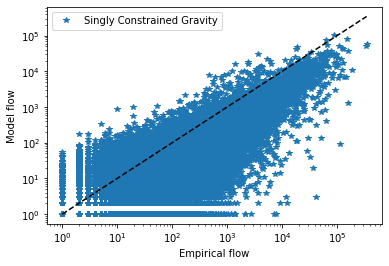

In [20]:
import matplotlib.pyplot as plt
# Actual and model flows for gravity model
g = fdf.merge(fdf_g, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
# Plot actual vs model flows
plt.plot(g[:,0], g[:,1], '*', label = 'Singly Constrained Gravity')
# Plot line x=y
x = np.logspace(0, np.log10(np.max(g)))
plt.plot(x, x, '--k')
# Plot attributes
plt.xlabel('Empirical flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog();
plt.show()

### 6. Radiation Model: Fit the data with the Radiation model. Show the scatter plot of data vs model

Import necessary packages

In [12]:
from skmob.models import Radiation

Initialize radiation model

In [13]:
radiation = Radiation()

Generate flows using radiation model

In [14]:
np.random.seed(0)
fdf_r = radiation.generate(tessellation, tile_id_column = 'tile_id',  tot_outflows_column = 'tot_outflow', 
                           relevance_column = 'population', out_format = 'flows_sample')

100%|██████████| 3140/3140 [01:25<00:00, 36.93it/s]


Scatter plot of data vs. model for radiation model

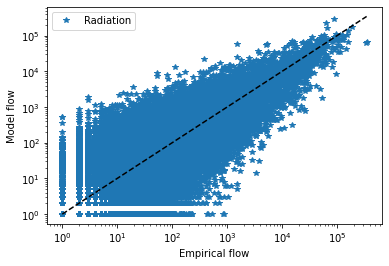

In [24]:
# Actual and model flows for radiation model
r = fdf.merge(fdf_r, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
# Plot actual vs model flows
plt.plot(r[:,0], r[:,1], '*', label = 'Radiation')
# Plot line x=y
x = np.logspace(0, np.log10(np.max(r)))
plt.plot(x, x, '--k')
# Plot attributes
plt.xlabel('Empirical flow')
plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog();
plt.show()

### 7. For the results of 4 and 6, report the CPC, the root mean square error, the R2 and the maximum error of each model.

Import necessary packages

In [25]:
from skmob.measures.evaluation import rmse, r_squared, max_error

Function for outputting requested metrics

In [26]:
def metrics(model, model_name):
    
    def cpc(values1, values2):
        return 2.0 * np.sum(np.minimum(values1, values2)) / (np.sum(values1) + np.sum(values2))
    
    # Names and functions of requested metrics
    metrics = [cpc, rmse, r_squared, max_error]
    names = ['common_part_of_commuters', 'rmse', 'r_squared', 'max_error']
    
    # Output metrics
    print(model_name)
    for i, metric in enumerate(metrics):
        m = metric(model[:, 0], model[:, 1])
        print("%s:   %s " % (names[i], np.round(m,5)))

Metrics for the singly constrained gravity model

In [27]:
metrics(g, "Singly Constrained Gravity Model")

Singly Constrained Gravity Model
common_part_of_commuters:   0.4487 
rmse:   3923.3146 
r_squared:   0.35335 
max_error:   288795 


Metrics for the radiation model

In [28]:
metrics(r, "Radiation Model")

Radiation Model
common_part_of_commuters:   0.6372 
rmse:   2251.23313 
r_squared:   0.54967 
max_error:   279995 


# Part II

Import necessary packages

In [15]:
import networkx as nx
import geopy.distance

Function for building undirected weighted graphs from data sets

In [27]:
def makeNetworkFromFiles(fedges, nodes, flow_i):

    # Create network graph
    G = nx.Graph()
    # Nodes
    fn = nodes.transpose()
    # Number of attributes
    n_attr = len(fn.index.values)
    # Attributes
    attr = fn.index.values
    
    # Add nodes to graph
    for n in fn.columns:
        attr_node = dict(list(zip(attr, fn[n].values)))
        G.add_node(n,attr_dic = attr_node)
        
    # Links
    fl = fedges
    fl.columns = list(map(str.lower, fl.columns))
    
    # Add (inter-flow) links to graph
    for L in fl.index.values:
        o_n = fl['origin'][L]
        d_n = fl['destination'][L]
        # If inter-flow
        if o_n != d_n:
            G.add_edge(fl['origin'][L],fl['destination'][L],weight=int(fl[flow_i][L]))
          
    # Set graph as largest connected component      
    G = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])

    return G

Adjust nodes file to have "tile_id" as the index

In [212]:
nodes["tile_id"] = nodes["tile_id"].astype(str)
nodes = nodes.set_index("tile_id")

Dataframe with actual and radiation model flows

In [29]:
network_flows = fdf.merge(fdf_r, on=['origin', 'destination']).rename(columns = {"flow_x": "actual_flows", "flow_y": "radiation_flows"})

Function for removing elemnts from a list if they equal a certain value

In [30]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

Create ntworks and determine network degrees

In [31]:
# Create networks
g_actual = makeNetworkFromFiles(network_flows, nodes, 'actual_flows')
g_radiation = makeNetworkFromFiles(network_flows, nodes, 'radiation_flows')

# Non-zero degrees for each network
degrees_actual = remove_values_from_list(list(dict(g_actual.degree()).values()),0)
degrees_radiation = remove_values_from_list(list(dict(g_radiation.degree()).values()),0)

# Non-zero weighted degrees for each network
w_degrees_actual=remove_values_from_list(list(dict(g_actual.degree(weight  = 'weight')).values()),0)
w_degrees_radiation=remove_values_from_list(list(dict(g_radiation.degree(weight  = 'weight')).values()),0)

### 1. For both the data and model, calculate the degree distributions of degree strengths or weighted degree.

Import necessary packages

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

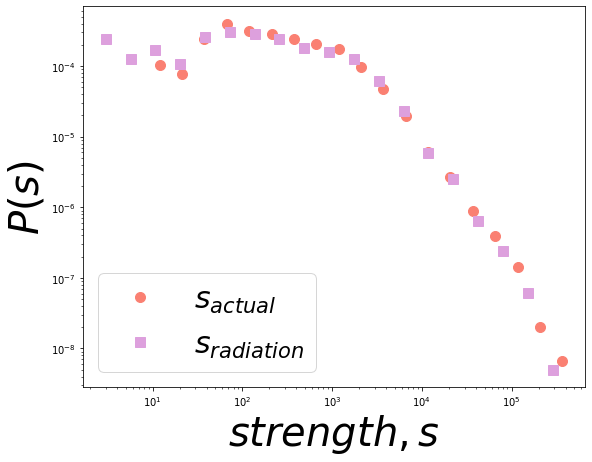

In [218]:
fig, ax = plt.subplots()
fig.set_size_inches((9, 7))

n_bins = 20
 
out_logBins = np.logspace(np.log10(min(w_degrees_actual)), np.log10(max(w_degrees_actual)),num=n_bins)
out_logBinDensity, out_binedges = np.histogram(w_degrees_actual, bins=out_logBins, density=True)

in_logBins = np.logspace(np.log10(min(w_degrees_radiation)), np.log10(max(w_degrees_radiation)),num=n_bins)
in_logBinDensity, in_binedges = np.histogram(w_degrees_radiation, bins=in_logBins, density=True)

ax.loglog(out_logBins[:-1],out_logBinDensity,'o', color = "salmon", markersize=10,label=r'$s_{actual}$')
ax.loglog(in_logBins[:-1],in_logBinDensity,'s', color = "plum", markersize=10,label=r'$s_{radiation}$')
ax.legend(fontsize=30)

ax.set_xlabel('$strength, s$',fontsize=40)
ax.set_ylabel('$P(s)$',fontsize=40);

### 2. Compare values of the two networks respect to: minimum/maximum degree, average degree, standard deviation of the average degree, average clustering coefficient, average shortest path

Function for outputting characteristics of networks

In [223]:
def characteristics(degrees, network, name):
    print("---------", name, "Network---------")
    print("Minimum Degree: ", min(degrees))
    print("Maximum Degree: ", max(degrees))
    print("Average Degree: ", np.mean(degrees))
    print("Standard Deviation of Degrees: ", np.std(degrees))
    print("Average Clustering Coefficient: ", nx.average_clustering(network, weight = "weight"))
    print("Average Shortest Path Length: ", nx.average_shortest_path_length(network, weight = "weight"))

Characteristics of the network

In [224]:
characteristics(degrees_actual, g_actual, name = "")

---------  Network---------
Minimum Degree:  1
Maximum Degree:  762
Average Degree:  44.336942675159236
Standard Deviation of Degrees:  51.3753376936526
Average Clustering Coefficient:  8.905942813691634e-05
Average Shortest Path Length:  10.965155847028244


Characteristics of the weighted network for the actual data

In [40]:
characteristics(w_degrees_actual, g_actual, "Weighted Actual")

---------Weighted Actual Network---------
Minimum Degree:  12
Maximum Degree:  651790
Average Degree:  11108.517834394905
Standard Deviation of Degrees:  33918.04130778616
Average Clustering Coefficient:  8.905942813691634e-05
Average Shortest Path Length:  10.965155847028244


Characteristics of the weighted network for the radiation model

In [41]:
characteristics(w_degrees_radiation, g_radiation, "Weighted Radiation")

---------Weighted Radiation Network---------
Minimum Degree:  3
Maximum Degree:  540394
Average Degree:  10581.822929936307
Standard Deviation of Degrees:  29030.162256072028
Average Clustering Coefficient:  8.959369476487066e-05
Average Shortest Path Length:  3.9429206834908275


### 5. Plot a power law function for the degree distribution: P(k) = C k^-gamma fixing K_min like in the commuting US network, and selecting gamma > 1 of your choice that K_max is close to the data

Import necessary packages

In [198]:
import powerlaw

Power law function variables

In [188]:
k_min = 12
N = g_actual.number_of_nodes()
gamma = 1.7385393
C = (gamma - 1) * (k_min ** (gamma - 1))

Check k_max ≈ 651,790

In [189]:
k_max = k_min * (N ** (1/(gamma - 1)))
k_max

651790.7810130437

Calculate power law function $P(k) = Ck^{-\gamma}$

In [191]:
w_k_list = list(dict(g_actual.degree(weight  = 'weight')).values())
w_k = np.array(w_k_list)
P = C * (w_k ** (-1 * gamma))

Plot weighted degree distribution with power law function

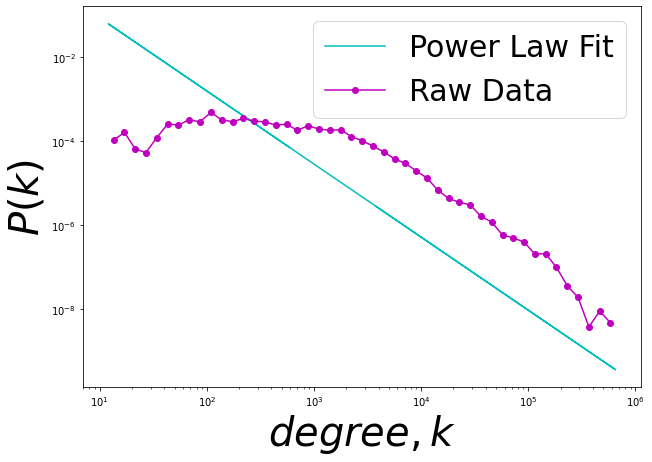

In [210]:
plt.figure(figsize = (10,7))
plt.loglog(w_k, P, color = "c", label = "Power Law Fit")
powerlaw.plot_pdf(w_degrees_actual, color = "m", marker= 'o', label='Raw Data')
plt.ylabel('$P(k)$', fontsize = 40)
plt.xlabel('$degree, k$', fontsize = 40)
plt.legend(loc = 'best', fontsize = 30);